In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### Cargamos el dataset

In [2]:
data= pd.read_csv('titanic.csv')
df=data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

Eliminamos las columnas que no son predicturas

Creamos cageogoricas

In [3]:
df=pd.get_dummies(df)

In [4]:
del df['Sex_female']

### Pequeña exploración de datos

In [5]:
df.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,,,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.852459,0.136612,0.085610,0.777778
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.318713,0.271930,0.087719,0.634503


Quitamos los NA's

In [6]:
df.isna().mean()

Survived      0.000000
Pclass        0.000000
Age           0.198653
SibSp         0.000000
Parch         0.000000
Fare          0.000000
Sex_male      0.000000
Embarked_C    0.000000
Embarked_Q    0.000000
Embarked_S    0.000000
dtype: float64

In [7]:
df['Age'] = df['Age'].fillna(df.Age.mean())

### Crea un modelo 

In [8]:
target = 'Survived'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Alejandro\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Predicciones del modelo, cuales son los tipos que hay 

In [9]:
probas = model.predict_proba(X_test)

probabilidades = [i[1] for i in probas]
predicciones = model.predict(X_test)

calibracion = pd.DataFrame({
    'target' : y_test,
    'probabilidades' : probabilidades,
    'predicciones': predicciones
})

### Calibracion

In [11]:
calibracion['bins']= pd.qcut(calibracion['probabilidades'], q=10, labels=False)+1
grouped = calibracion.groupby('bins').mean()


,target,probabilidades,predicciones
bins,,,
1,0.185185,0.073588,0.000000
2,0.035714,0.114507,0.000000
3,0.115385,0.137438,0.000000
4,0.148148,0.172625,0.000000
5,0.115385,0.242587,0.000000
6,0.296296,0.339792,0.000000
7,0.423077,0.530670,0.615385
8,0.592593,0.657132,1.000000
9,0.814815,0.775783,1.000000


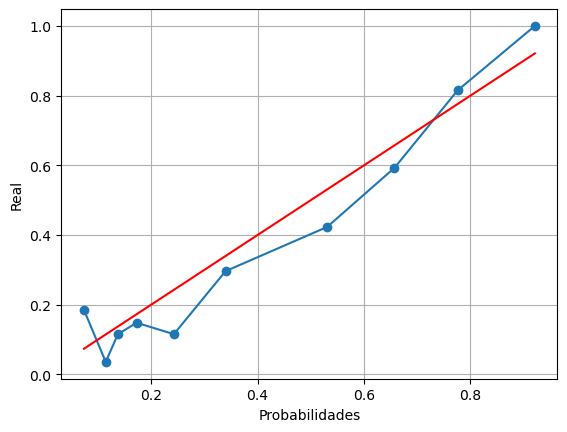

In [12]:
plt.plot(grouped.probabilidades, grouped.target, marker='o')
plt.plot(grouped.probabilidades, grouped.probabilidades, color='red')
plt.xlabel('Probabilidades')
plt.ylabel('Real')
plt.grid()

### ¿Qué tanto le atina?

In [44]:
np.mean(calibracion.predicciones == calibracion.target)

0.8022388059701493

Con sklearn 

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
accuracy_score(y_pred=calibracion.predicciones, y_true=calibracion.target)

0.8022388059701493

###  Histogramas 

In [47]:
prob_1=calibracion.query('target==1').probabilidades
prob_0=calibracion.query('target==0').probabilidades


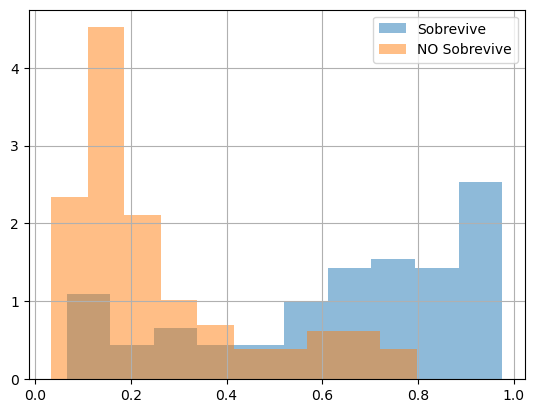

In [48]:
plt.hist(prob_1, alpha=0.5, density=True, label='Sobrevive')
plt.hist(prob_0, alpha=0.5, density=True, label='NO Sobrevive')
plt.grid()
plt.legend()
plt.show()

### Usando statsmodel

In [49]:
import statsmodels.formula.api as smf
df = pd.read_csv('titanic.csv')

In [50]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [54]:
model = smf.logit('Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)', data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                            9
Date:                Thu, 20 Feb 2025   Pseudo R-squ.:                  0.3419
Time:                        21:23:54   Log-Likelihood:                -316.17
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 2.249e-65
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.4329      0.536      8.271      0.000       3.383       5.483
C(Pclass)[T